# Setup

In [7]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.feature_selection import SelectFromModel, SelectKBest, chi2, mutual_info_classif, RFE
from sklearn.preprocessing import StandardScaler, FunctionTransformer, OrdinalEncoder, LabelEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score, RandomizedSearchCV
from sklearn.base import BaseEstimator, TransformerMixin
from category_encoders.target_encoder import TargetEncoder
from category_encoders.count import CountEncoder
from category_encoders.hashing import HashingEncoder
from category_encoders.woe import WOEEncoder
from category_encoders.polynomial import PolynomialEncoder
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.model_selection import learning_curve
from xgboost import XGBClassifier
from imblearn import pipeline as imb_pipe
from imblearn.under_sampling import RandomUnderSampler, NearMiss, OneSidedSelection, NeighbourhoodCleaningRule
from imblearn.combine import SMOTEENN, SMOTETomek
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.svm import SVR
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import seaborn as sns

# Цели и задачи

* Отток клиентов – это потеря клиентов, выраженное в отсутствии покупок или платежей в течение определенного периода времени.
* Цель – уменьшить количество уходящих клиентов
* Задача – создать модель прогнозирования оттока клиентов для проведения компании по удержанию. Бинарная классификация, целевая переменная – вероятность оттока

# Постановка задачи

Данные были предоставлены французской телекоммуникационной компанией Orange. Клиентских данные были предварительно обфусцированы и анонимизированны: из датасета убрана любая персональная информация, позволяющая идентифицировать пользователей, а также не представлены названия и описания переменных, предназначенных для построения прогнозов. Датасет состоит из 50 тыс. объектов и включает 230 переменных, из которых первые 190 переменных - числовые, и оставшиеся 40 переменные - категориальные

# Построение модели

In [8]:
class RocAucScoring:
    def __init__(self, estimator):
        self._estimator = estimator
        self._name, *_ = estimator['classifier'].__class__.__name__
        #self._X_train = X_train
        #self._y_train = y_train
        
    def fit_test(self, X_test, y_test):
        #self._estimator.fit(self._X_train, self._y_train)
        self._predict = self._estimator.predict_proba(X_test)[:,1]
        self._fpr, self._tpr, _ = metrics.roc_curve(y_true=y_test, y_score=self._predict)
        self._roc_auc = metrics.auc(self._fpr, self._tpr)
        self._roc_auc_score = metrics.roc_auc_score(y_true=y_test, y_score=self._predict)
        return self
        
    def plot(self, title=''):
        plt.title(f'ROC {round(self._roc_auc_score, 4)} {self._name} {title}')
        plt.plot(self._fpr, self._tpr, 'b', label = 'AUC = %0.2f' % self._roc_auc)
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()

        return self


In [7]:
class CrossValidateReport:
    def __init__(self, pipe, X, y, cv, weight=None):
        self._pipe = pipe
        self._X = X
        self._y = y
        self._cv = cv
        self._tprs = []
        self._aucs = []
        self._mean_fpr = np.linspace(0, 1, 100)
        _, self._ax = plt.subplots(figsize=(10, 5))
        self._name = pipe['classifier'].__class__.__name__
        self._weight = weight
        
    def _get_sample_weight(self, y):
        w = np.zeros(len(y))
        
        cl0_weight, cl1_weight = self._weight
        
        w[y == 1] = self._cl1_weight
        w[y == 0] = self._cl0_weight

        return w

    def _roc_plot(self, X, y, title=''):
        viz = metrics.RocCurveDisplay.from_estimator(
            self._pipe,
            X,
            y,
            name=title,
            alpha=0.3,
            lw=1,
            ax=self._ax,
        )
        interp_tpr = np.interp(self._mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        self._tprs.append(interp_tpr)
        self._aucs.append(viz.roc_auc)

    def _diag_plot(self):
        self._ax.plot([0, 1], [0, 1], linestyle="--", lw=2,
                      color="r", label="Chance", alpha=0.8)

    def _mean_roc_plot(self):
        self._mean_tpr = np.mean(self._tprs, axis=0)
        self._mean_tpr[-1] = 1.0
        self._mean_auc = metrics.auc(self._mean_fpr, self._mean_tpr)
        std_auc = np.std(self._aucs)
        self._ax.plot(
            self._mean_fpr,
            self._mean_tpr,
            color="b",
            label=r"Mean ROC (AUC = %0.2f $\pm$ %0.2f)" % (self._mean_auc, std_auc),
            lw=2,
            alpha=0.8,
        )

    def _fill_roc_fold_diff(self):
        std_tpr = np.std(self._tprs, axis=0)

        tprs_upper = np.minimum(self._mean_tpr + std_tpr, 1)
        tprs_lower = np.maximum(self._mean_tpr - std_tpr, 0)
        self._ax.fill_between(
            self._mean_fpr,
            tprs_lower,
            tprs_upper,
            color="grey",
            alpha=0.2,
            label=r"$\pm$ 1 std. dev.",
        )

    def plot(self, title=''):
        self._diag_plot()

        for i, (train_indx, test_indx) in enumerate(cv.split(self._X, self._y)):
            X_train = self._X.iloc[list(train_indx), :]
            y_train = self._y[train_indx]
            X_test = self._X.iloc[list(test_indx), :]
            y_test = self._y[test_indx]
            
            if self._weight:
                w = self._get_sample_weight(y_train)
                self._pipe.fit(X_train, y_train, classifier__sample_weight=w)
            else:
                self._pipe.fit(X_train, y_train)

            self._roc_plot(X_test, y_test, title=f'ROC fold-{i}')

        self._mean_roc_plot()
        self._fill_roc_fold_diff()

        self._ax.set(
            xlim=[-0.05, 1.05],
            ylim=[-0.05, 1.05],
            title=f'ROC: {round(self._mean_auc, 4)} {self._name} {title}',
        )
        
        self._ax.legend(loc="lower right")
        plt.show()
        
        print(self._mean_auc)
        
        return self
    

In [2]:
class LearningCurve:
    def __init__(self, estimator, cv=None, train_sizes=np.linspace(0.1, 1.0, 5)):
        self._estimator = estimator
        self._cv = cv
        self._train_sizes = train_sizes
        self._name = estimator['classifier'].__class__.__name__

    def fit(self, X, y):
        res = learning_curve(
            self._estimator,
            X,
            y,
            cv=self._cv,
            n_jobs=-1,
            train_sizes=self._train_sizes,
            return_times=True)
        
        self._train_sizes = res[0]
        self._train_scores = res[1]
        self._test_scores = res[2]
        self._fit_times = res[3]
        
        self._train_scores_mean = np.mean(self._train_scores, axis=1)
        self._train_scores_std = np.std(self._train_scores, axis=1)
        self._test_scores_mean = np.mean(self._test_scores, axis=1)
        self._test_scores_std = np.std(self._test_scores, axis=1)
        
        return self

    def plot(self):
        plt.title(f'{self._name}Learning curve')
        plt.xlabel("Training examples")
        plt.ylabel("Score")
        
        plt.grid()
        plt.fill_between(
            self._train_sizes,
            self._train_scores_mean - self._train_scores_std,
            self._train_scores_mean + self._train_scores_std,
            alpha=0.1,
            color="r",
        )
        plt.fill_between(
            self._train_sizes,
            self._test_scores_mean - self._test_scores_std,
            self._test_scores_mean + self._test_scores_std,
            alpha=0.1,
            color="g",
        )
        plt.plot(
            self._train_sizes, self._train_scores_mean, "o-", color="r", label="Training score"
        )
        plt.plot(
            self._train_sizes, self._test_scores_mean, "o-", color="g", label="Cross-validation score"
        )
        plt.legend(loc="best")
        plt.show()
        
        print(f'Train score mean: {self._train_scores_mean} Test score mean: {self._test_scores_mean}')
        return self


In [104]:
def feature_importance_report(estimator, top_count=5):
    coef = estimator.named_steps['selector'].estimator_.coef_
    names = estimator.feature_names_in_
    df = pd.DataFrame(zip(names, coef), columns=["feature", "value"])
    
    df["abs_value"] = df["value"].apply(lambda x: abs(x))
    df["colors"] = df["value"].apply(lambda x: "green" if x > 0 else "red")
    df = df.sort_values("abs_value", ascending=False)
    
    fig, ax = plt.subplots(1, 1, figsize=(12, 7))
    sns.barplot(x="feature",
                y="value",
                data=df.head(top_count),
               palette=df.head(top_count)["colors"])
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)
    ax.set_title(f"Top {top_count} Features", fontsize=25)
    ax.set_ylabel("Coef", fontsize=22)
    ax.set_xlabel("Feature Name", fontsize=22)

In [9]:
def load_data(X_csv, y_csv):
    X = pd.read_csv(X_csv).drop(columns='Unnamed: 0')
    y = pd.read_csv(y_csv).drop(columns='Unnamed: 0')    
    y[y == -1] = 0
    
    return X, np.ravel(y)

def get_features(df):
    cat_features = df.iloc[: , df.columns.get_loc("Var191"):].columns
    num_features = df.iloc[: , :df.columns.get_loc("Var191")].columns
    
    return cat_features, num_features

X_train, y_train = load_data('train-data.csv', 'train-labels.csv')
X_test, y_test = load_data('hold-out-data.csv', 'hold-out-labels.csv')

cat_features_all, num_features_all = get_features(X_train)


## Baseline градиентный бустинг

При построении basline решения, лучше всего показали себя алгоритмы градиентного бустинга и random forest. Провдеем сравнительный анализ популярных реализаций для градиентного бустинга. 

### Pipeline

In [4]:
default_num_transformer = make_pipeline(
    SimpleImputer(missing_values=np.nan, strategy='constant')
)

default_categorical_transformer = make_pipeline(
    SimpleImputer(missing_values=np.nan, strategy='constant'),
    OrdinalEncoder(),
    StandardScaler(),
)

default_preprocessor = make_column_transformer(
    (default_num_transformer, num_features_all),
    (default_categorical_transformer, cat_features_all),
)

classifiers = [
    GradientBoostingClassifier(),
    XGBClassifier(use_label_encoder=False,
                  eval_metric='logloss', n_jobs=-1),
    CatBoostClassifier(  # iterations=500,
        # depth=2,
        # l2_leaf_reg=5,
        early_stopping_rounds=50,
        eval_metric='AUC',
        # random_strength=1,
        leaf_estimation_method='Newton',
        boosting_type='Ordered',
        learning_rate=0.1,
        verbose=False),
    LGBMClassifier(n_jobs=-1)
]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

### Baseline

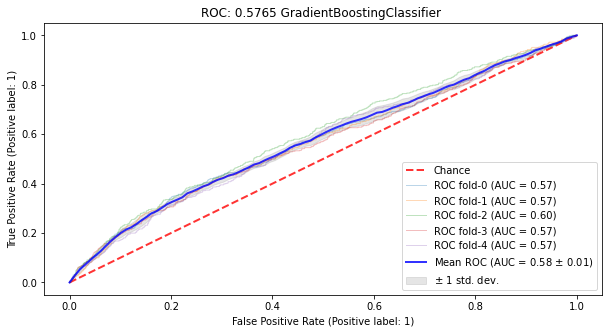

0.5764545669004267


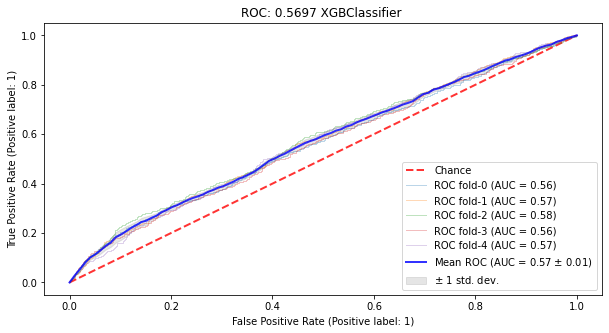

0.5696948251088377


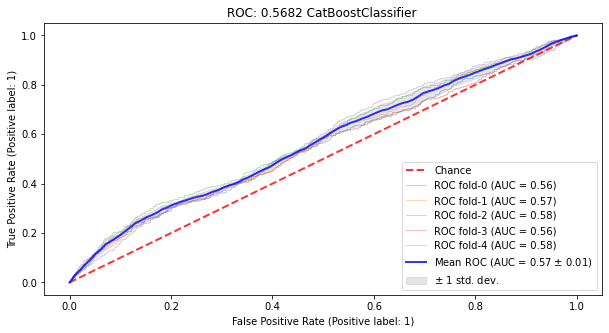

0.5681678783589612


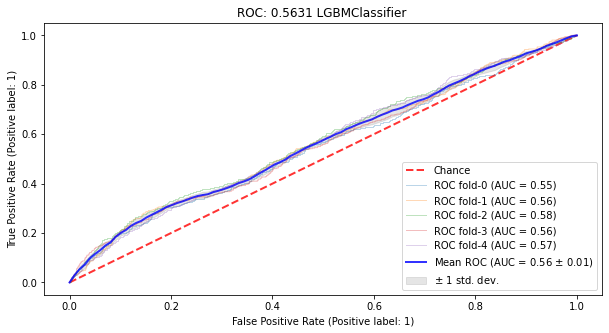

0.5631195178965879


In [61]:
for clf in classifiers:
    pipe = Pipeline(steps=[
        ('preprocessor', default_preprocessor),
        ('classifier', clf)
    ])

    CrossValidateReport(pipe, X_train, y_train, cv).plot()


Baseline решение: 0.5743391122345499

## Кривая обучения

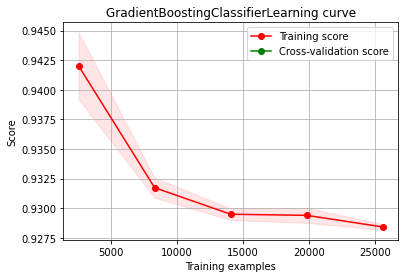

Train score mean: [0.94203125 0.93173077 0.92948864 0.92939516 0.92841406] Test score mean: [nan nan nan nan nan]


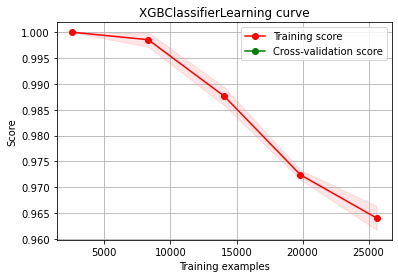

Train score mean: [1.         0.99855769 0.98761364 0.97241935 0.96407031] Test score mean: [nan nan nan nan nan]


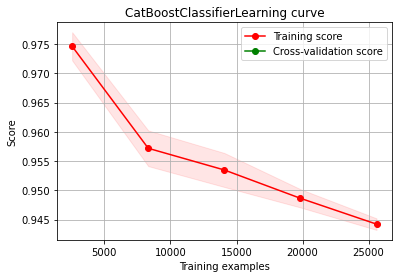

Train score mean: [0.97460938 0.9571875  0.95348011 0.94863911 0.94422656] Test score mean: [nan nan nan nan nan]


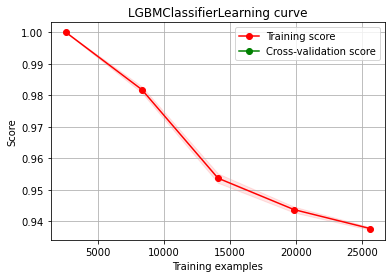

Train score mean: [1.         0.98177885 0.95367898 0.9436996  0.9376875 ] Test score mean: [nan nan nan nan nan]


In [5]:
for clf in classifiers:
    pipe = Pipeline(steps=[
        ('preprocessor', default_preprocessor),
        ('classifier', clf)
    ])
   
    LearningCurve(pipe, cv=cv).fit(X_train, y_train).plot()

Кривая обучения кроссвалидации растет с увеличением размера выборки. Уменьшать выборку нельзя.

## Выравнивание баланса классов

### Баланс весов

Pipeline немного отличается у реализаций алгоритма. Проверим сначала на GradientBoostingClassifier.

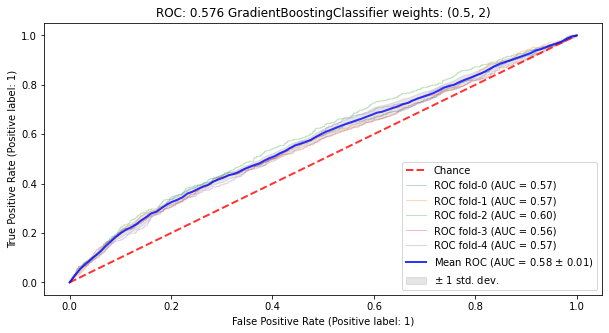

0.5759870466876837


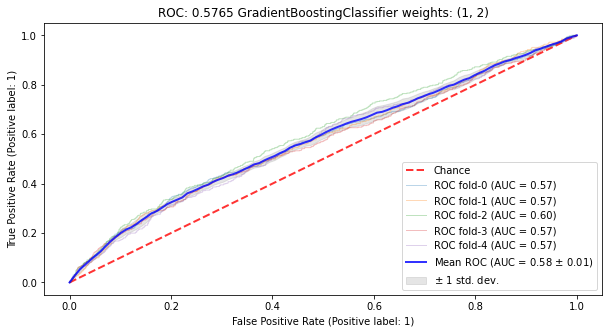

0.5764974586630638


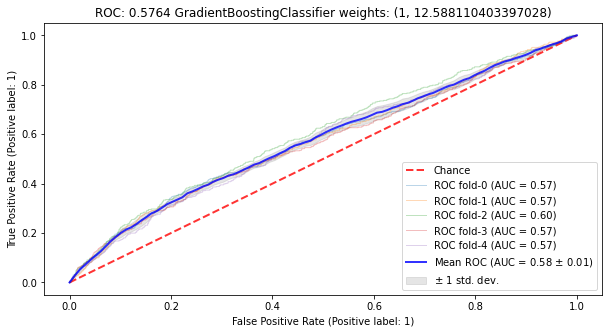

0.5764159643140534


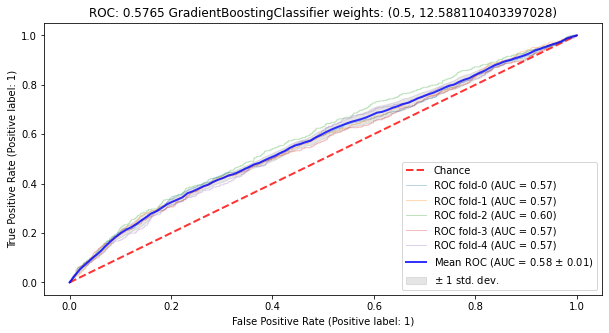

0.5765231937206459


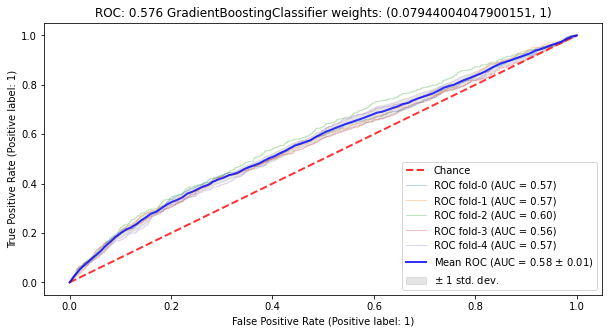

0.5759741791588926


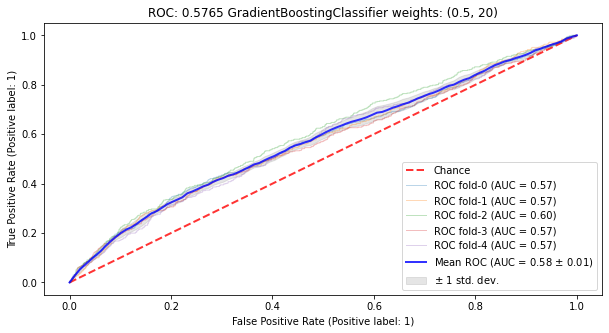

0.5764760127817452


In [77]:
multiplier = len(y_train[y_train == 0]) / len(y_train[y_train == 1])
weights = [(0.5, 2), (1, 2), (1, multiplier),
           (0.5, multiplier), (1 / multiplier, 1), (0.5, 20)]

for w_coeff in weights:
        pipe = Pipeline(steps=[
            ('preprocessor', default_preprocessor),
            ('classifier', GradientBoostingClassifier())
        ])
        
        CrossValidateReport(pipe, X_train, y_train, cv, weight=weights).plot(title=f'weights: {w_coeff}')

Изменение коэффициентов весов дало небольшой прирост на GradientBoostingClassifier (auc 0.58->0.60). XGBClassifier не показал улучшений. Попробуем другие методы.

### Комбинирование oversampling и undersampling

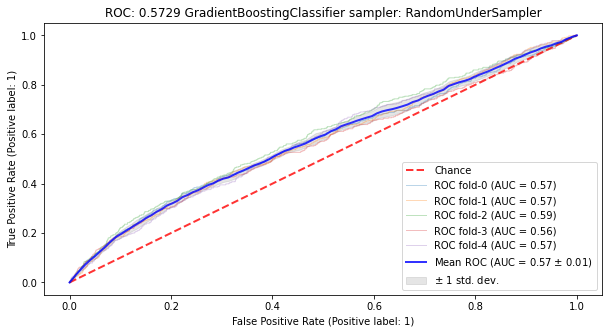

0.5729217153845604


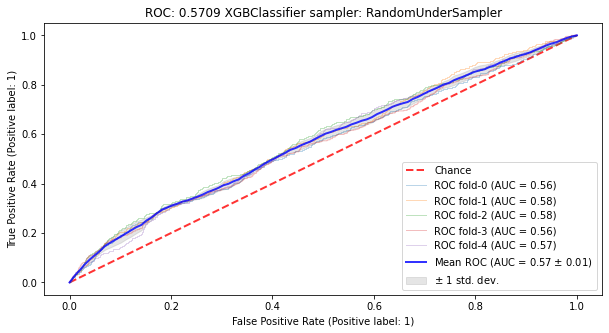

0.5709129511677283


Custom logger is already specified. Specify more than one logger at same time is not thread safe.

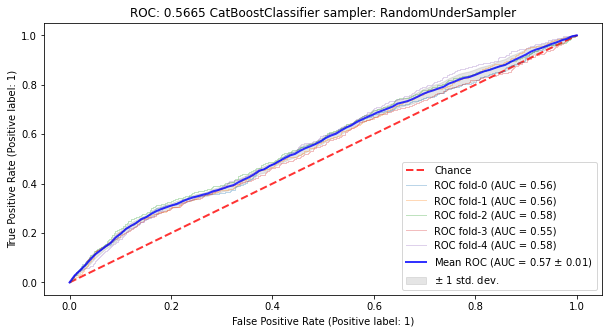

0.5665294130262283


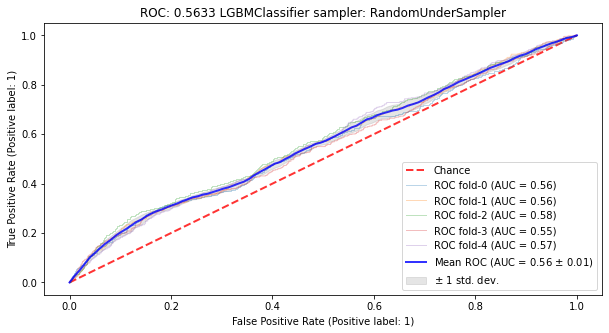

0.5632696390658174


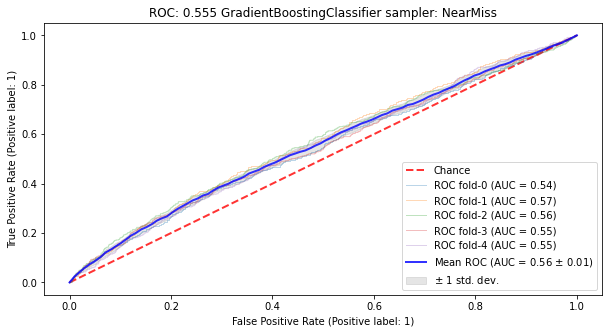

0.5550129747581977


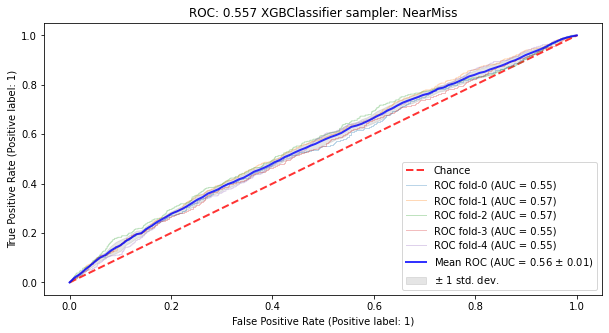

0.5570160200733448


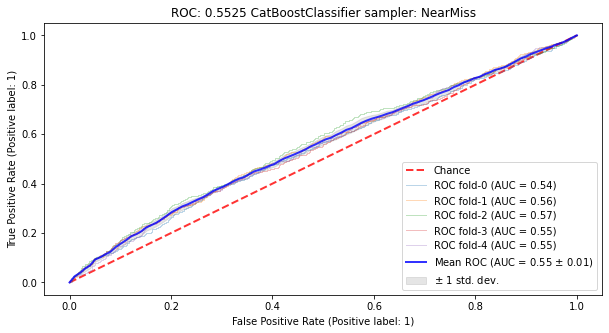

0.5524823607626155


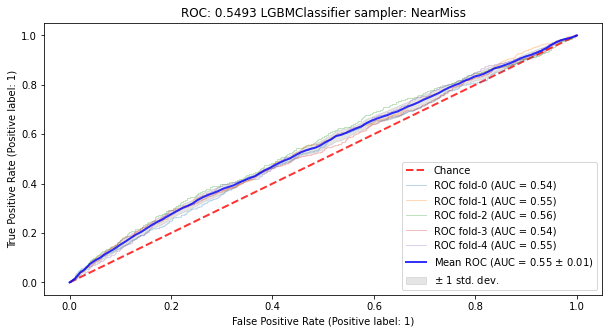

0.5493040811512149


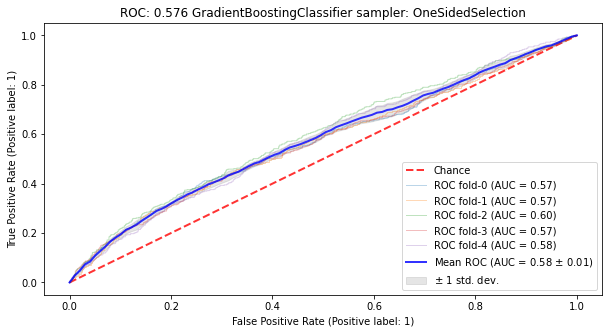

0.5760356573520056


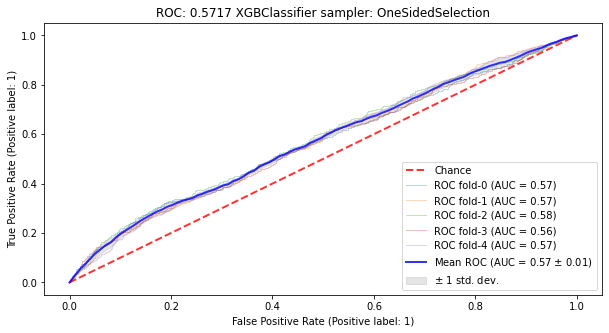

0.5717321838340945


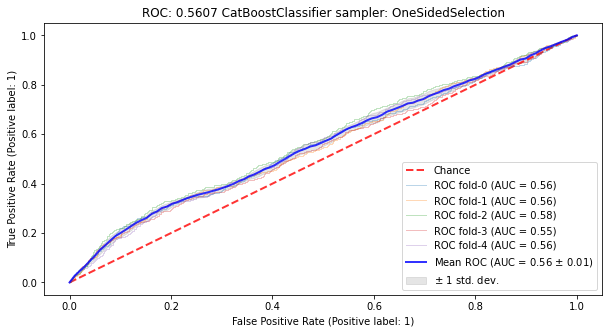

0.5607261575414442


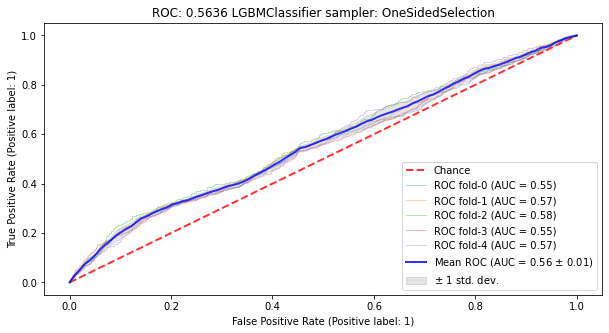

0.5635655922280126


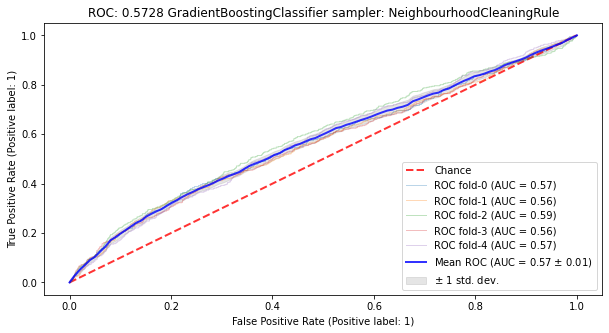

0.5727963761226323


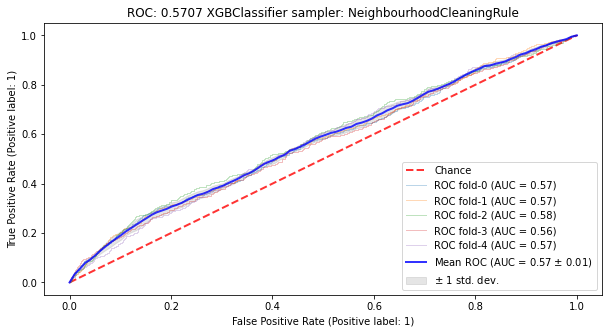

0.5706856248257522


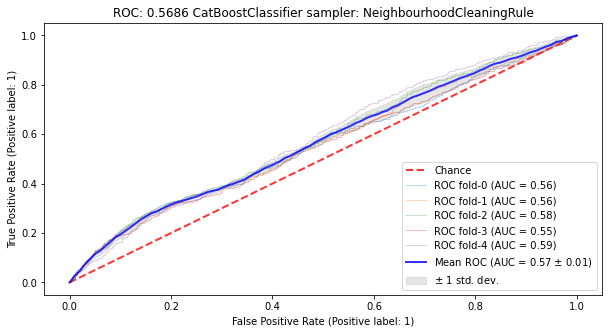

0.5685925068090673


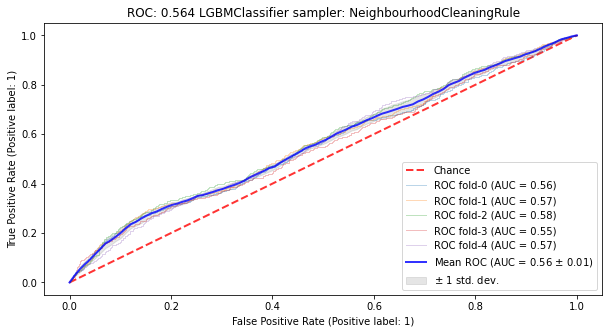

0.5639559072680091


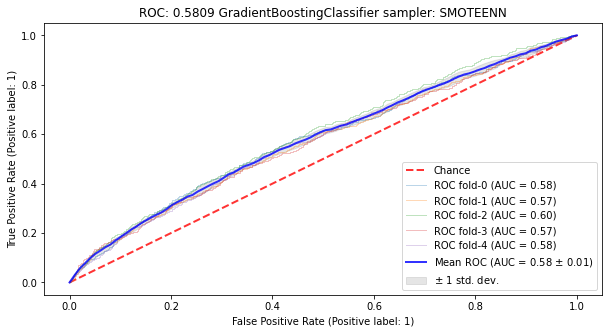

0.5809238885672006


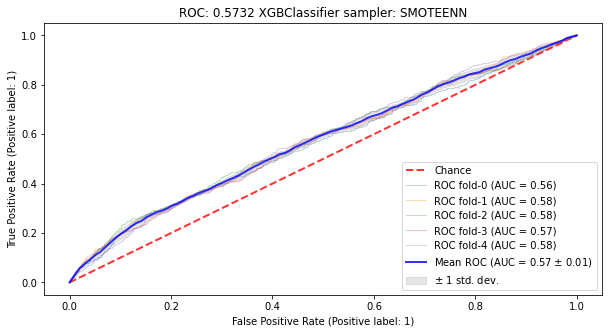

0.5732033712925432


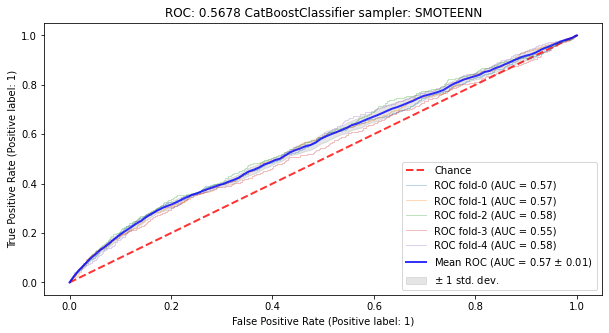

0.5678376117866564


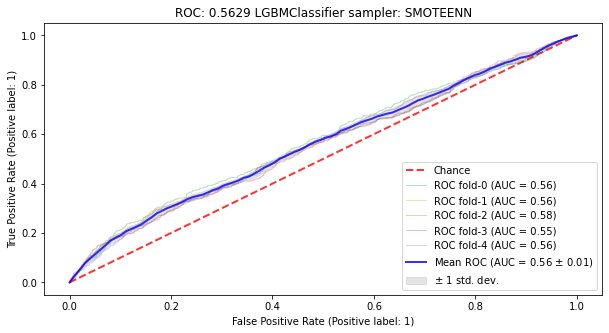

0.5629479508460399


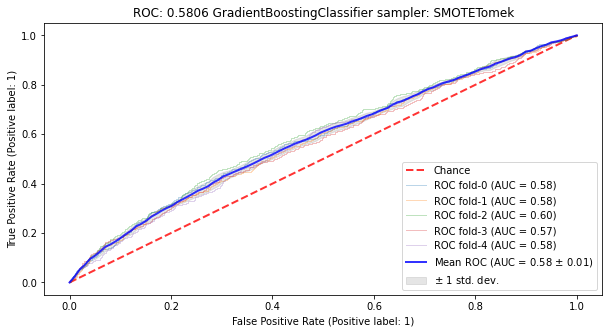

0.5805678869373136


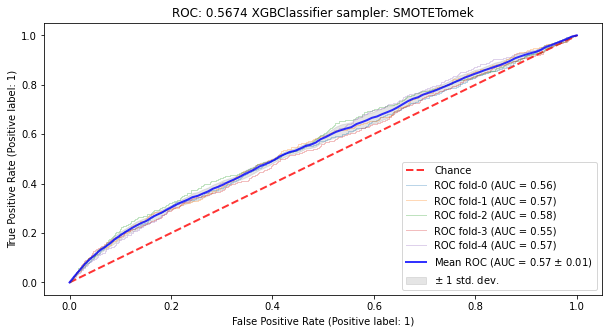

0.5673658023976496


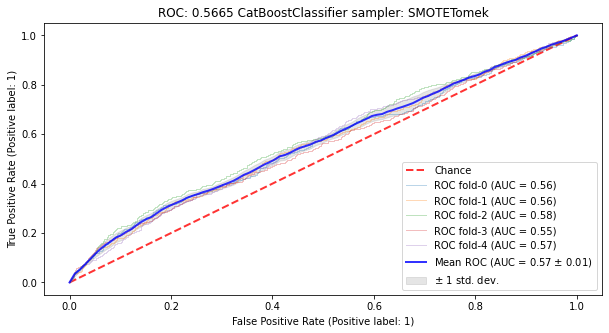

0.5665208346737008


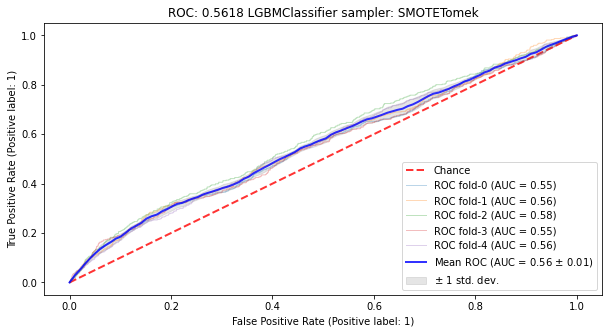

0.5617731931249269


In [78]:
samplers = [
    RandomUnderSampler(sampling_strategy=1/10, random_state=0),
    NearMiss(version=3, n_neighbors_ver3=3, n_jobs=-1),
    OneSidedSelection(random_state=0, n_jobs=-1),
    NeighbourhoodCleaningRule(n_neighbors=3, threshold_cleaning=0.5, n_jobs=-1),   
    SMOTEENN(sampling_strategy=1, random_state=0, n_jobs=-1),
    SMOTETomek(sampling_strategy=1, random_state=0, n_jobs=-1)
]

for sampler in samplers:
    for clf in classifiers:
        pipe = imb_pipe.Pipeline(steps=[
            ('preprocessor', default_preprocessor),
            ('sampler', sampler),
            ('classifier', clf),
        ])

        CrossValidateReport(pipe, X_train, y_train, cv).plot(title=f'sampler: {sampler.__class__.__name__}')


Лучше всего себя показал SMOTEENN, на классификаторах GradientBoostingClassifier и XGBClassifier.

# Стратегии заполения входных данных

In [81]:
def build_pipe(clf, num_transformer=None, cat_transformer=None):
    preprocessor = make_column_transformer(
        (num_transformer, num_features_all),
        (cat_transformer, cat_features_all),
    )

    return Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('classifier', clf)
    ])


default_num_transformer = make_pipeline(
    SimpleImputer(missing_values=np.nan, strategy='median'))

default_cat_transformer = make_pipeline(
    SimpleImputer(missing_values=np.nan, strategy='constant'),
    TargetEncoder())


### Непрерывные данные

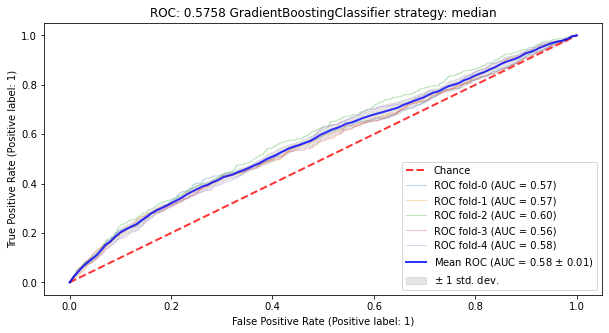

0.575781166227026


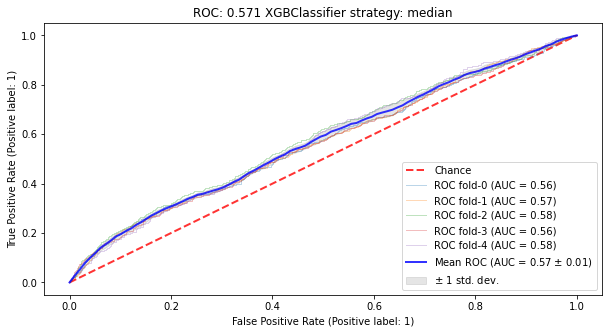

0.5709644212828926


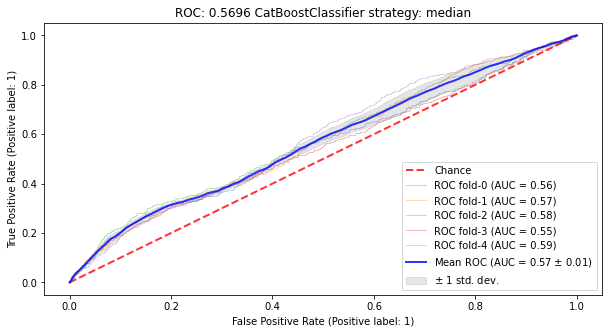

0.5695618606446632


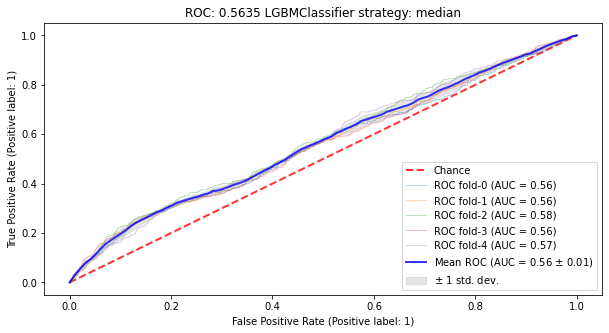

0.5634540736451565


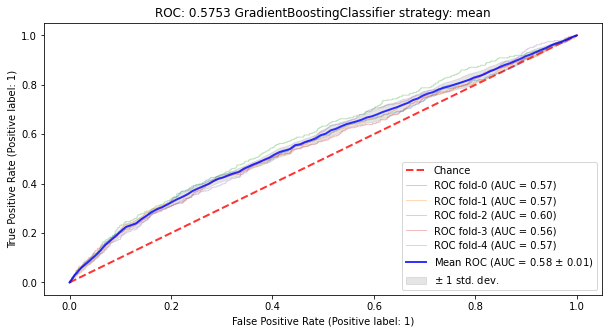

0.5752740902776289


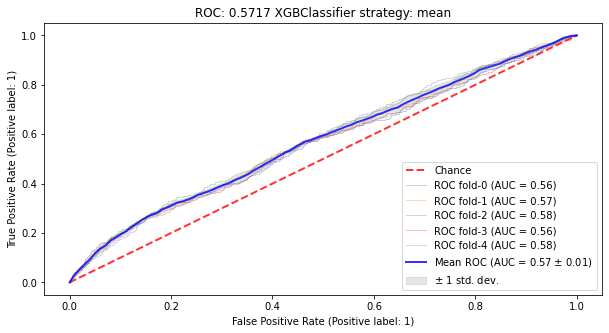

0.571710737952776


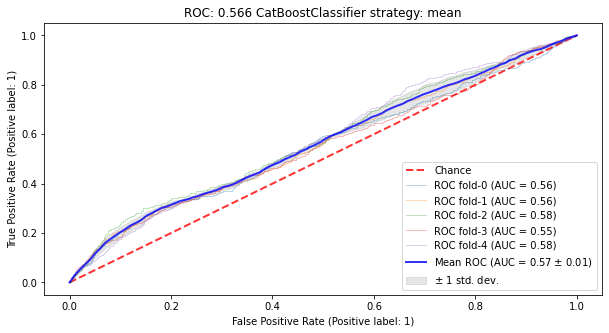

0.5659846876407386


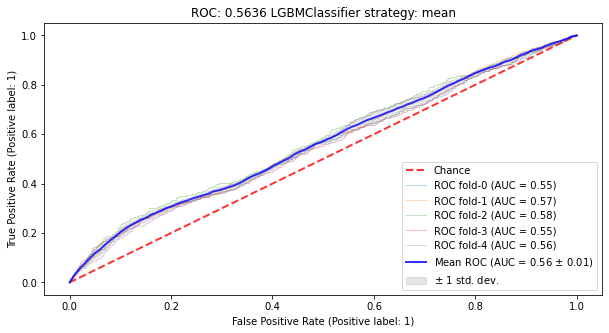

0.5636385082244955


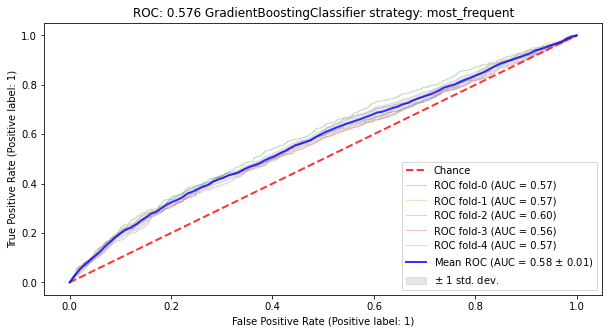

0.5759784683351563


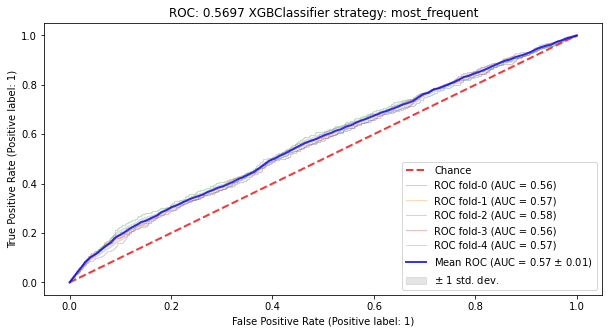

0.5696948251088377


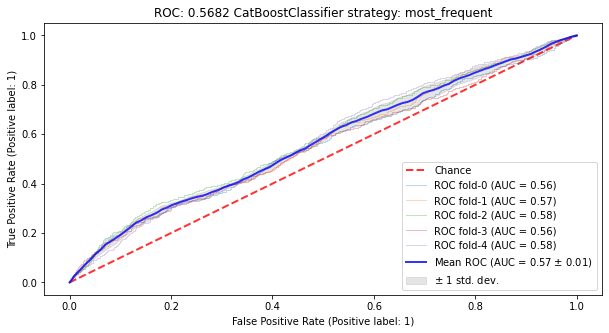

0.5681678783589612


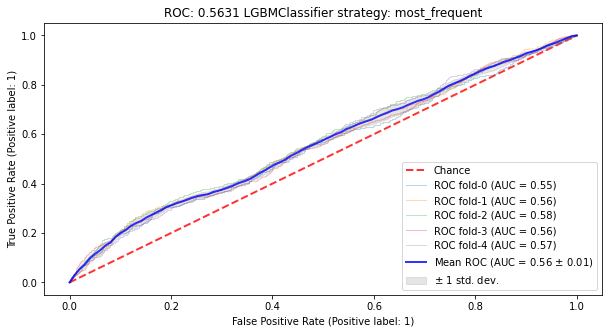

0.5631195178965879


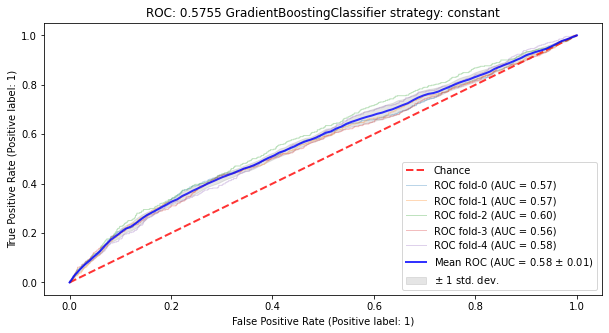

0.5754578099942573


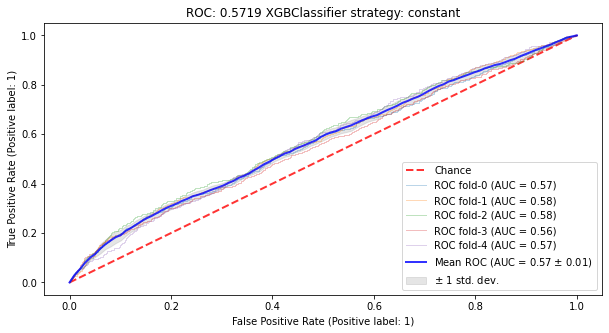

0.5718780158270603


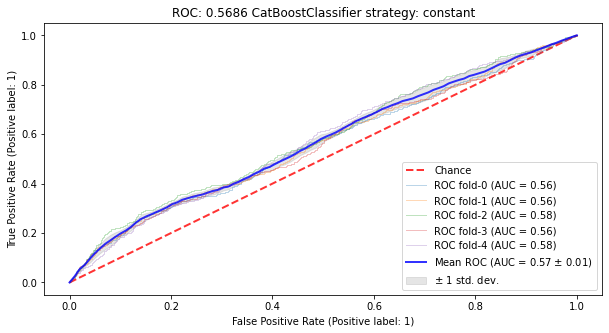

0.5685882176328035


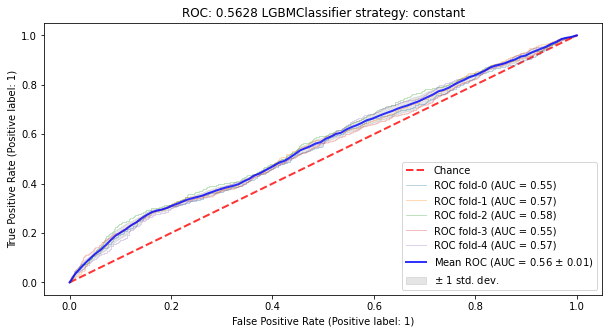

0.5627849621480194


In [83]:
num_fill_strategies = ['median', 'mean', 'most_frequent', 'constant']

for strategy in num_fill_strategies:
    num_tranformer = make_pipeline(SimpleImputer(
        missing_values=np.nan, strategy=strategy))

    for clf in classifiers:
        pipe = build_pipe(clf, num_transformer=num_tranformer,
                          cat_transformer=default_cat_transformer)

        CrossValidateReport(pipe, X_train, y_train, cv).plot(
            title=f'strategy: {strategy}')

### Категориальные данные

На этапе обработки данных, кодирование категорий оказало наиболее сильное влияние на оценку. Рассмотрим несколько энкодеров.

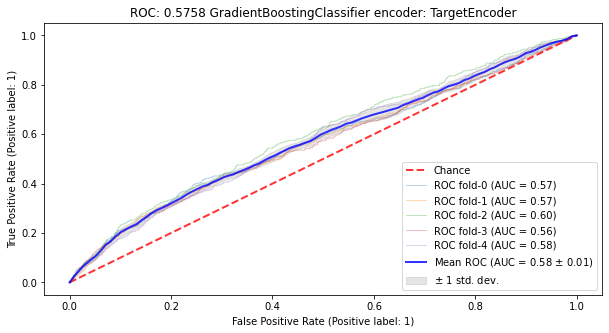

0.5757506654180398


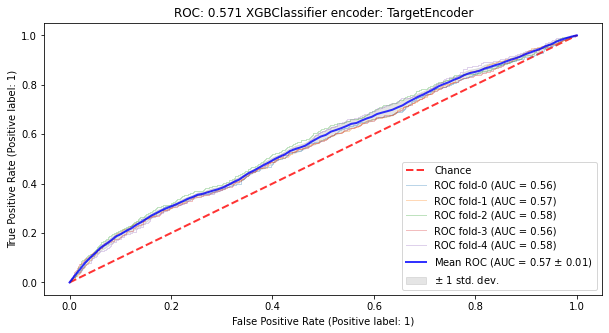

0.5709644212828926


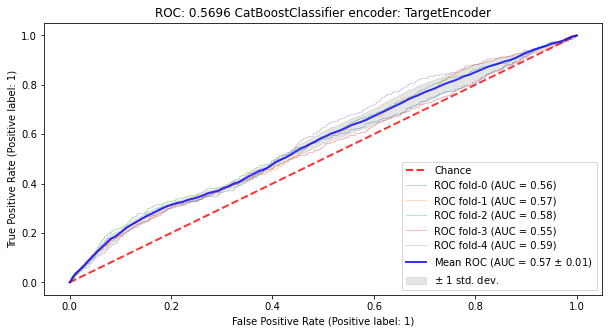

0.5695618606446632


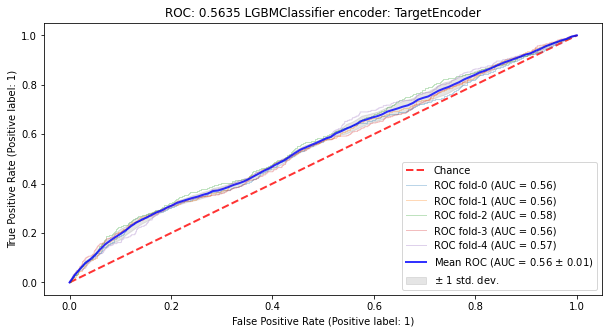

0.5634540736451565


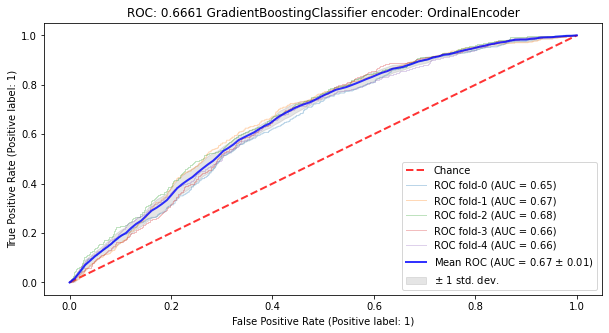

0.6661498209268909


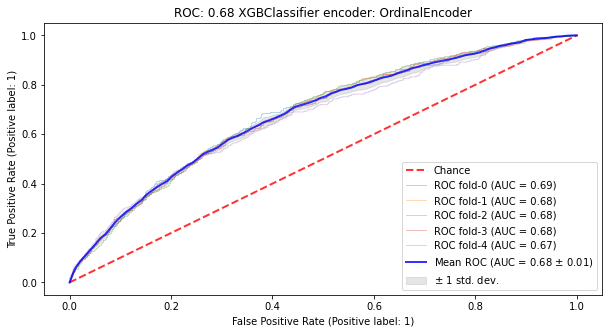

0.6800338844924831


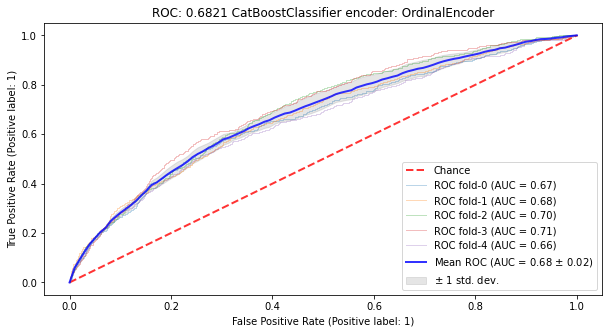

0.6821098458041133


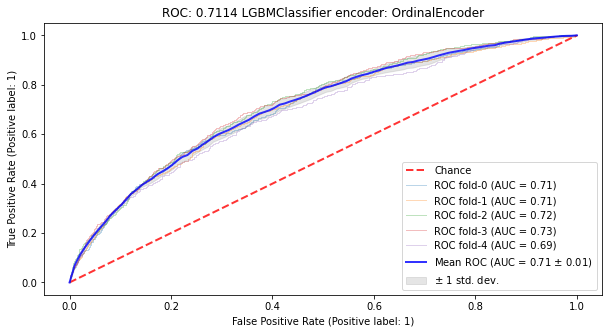

0.7114092088614382


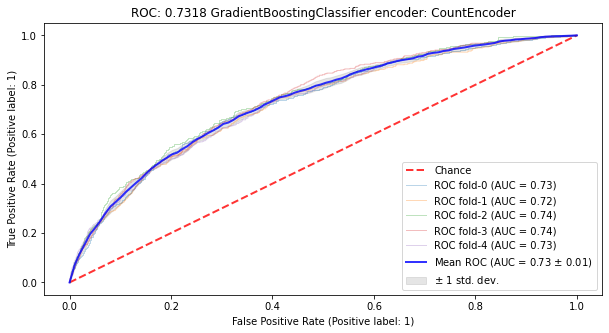

0.7318471337579618


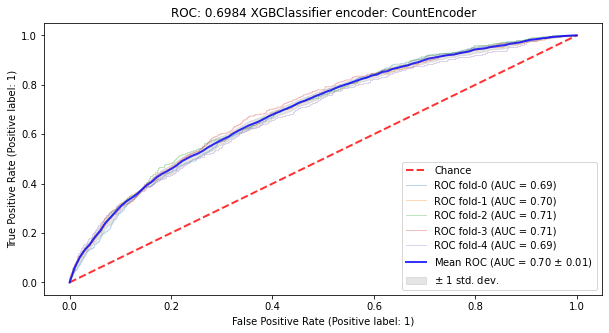

0.6984087156061678


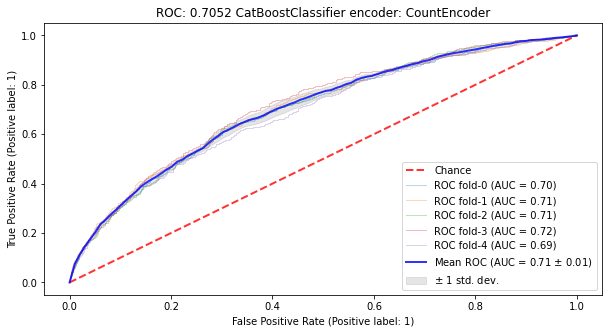

0.7051598790452295


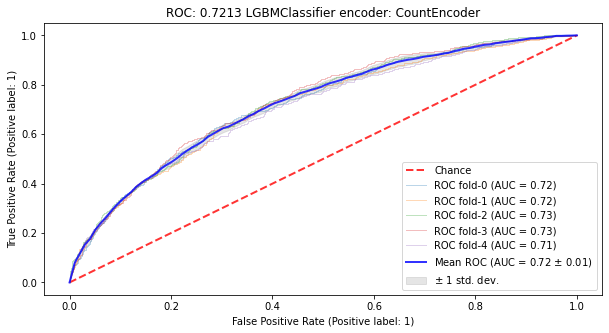

0.721342941088164


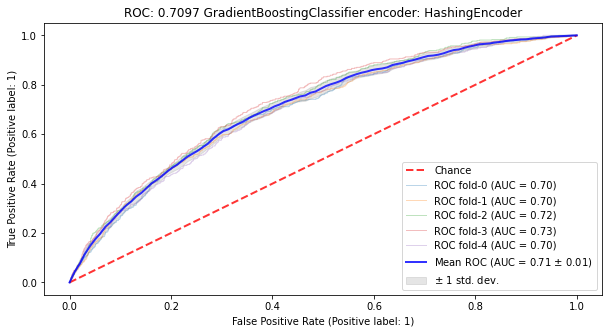

0.7096732812046781


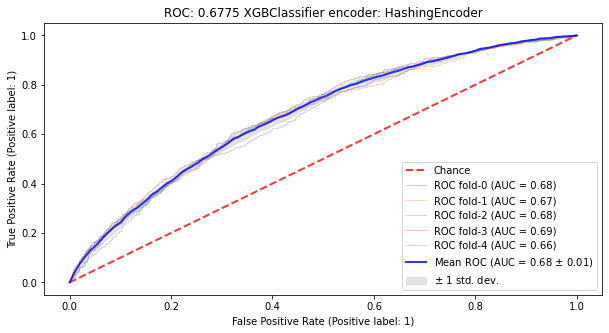

0.6774989813206374


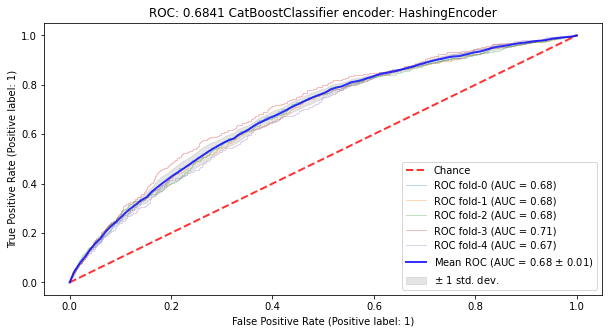

0.6841429153531065


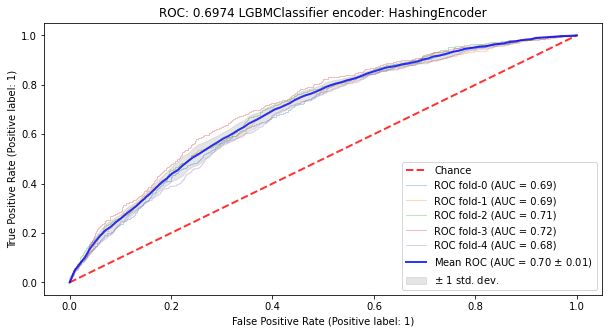

0.6973921808316712


In [96]:
cat_encoders = [
    TargetEncoder(),
    OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
    CountEncoder(handle_unknown='value'),
    HashingEncoder(),
]

for cat_encoder in cat_encoders:
    cat_transformer = make_pipeline(
        SimpleImputer(missing_values=np.nan, strategy='constant'),
        cat_encoder)

    for clf in classifiers:
        pipe = build_pipe(
            clf, num_transformer=default_num_transformer, cat_transformer=cat_transformer)

        CrossValidateReport(pipe, X_train, y_train, cv).plot(
            title=f'encoder: {cat_encoder.__class__.__name__}')


CountEncoder и OrdinalEncoder показали себя лучше всего.

## Отбор признаков

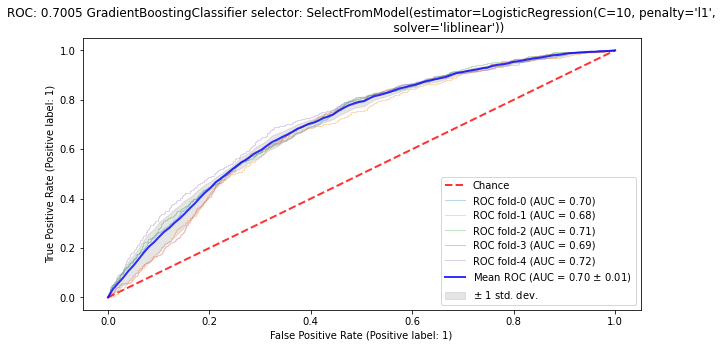

0.7005208966284691


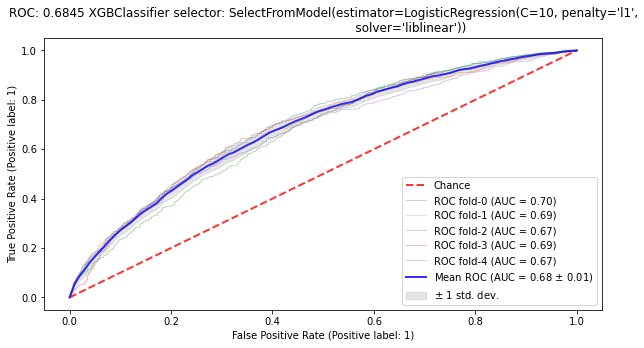

0.6845289412168393


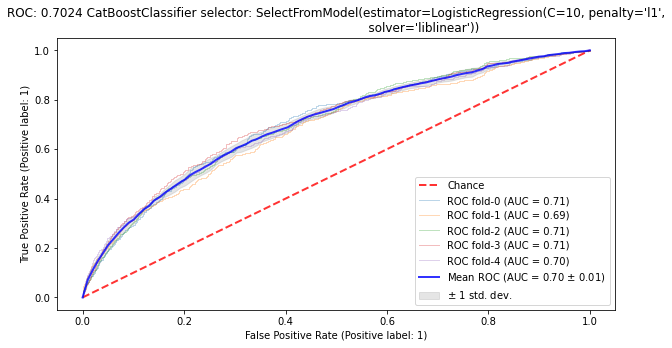

0.7024362521177808


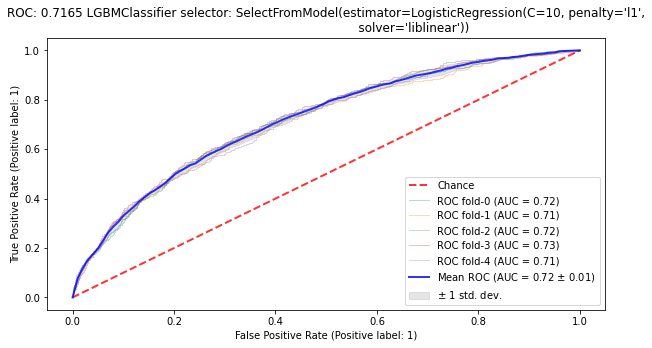

0.716517617791503


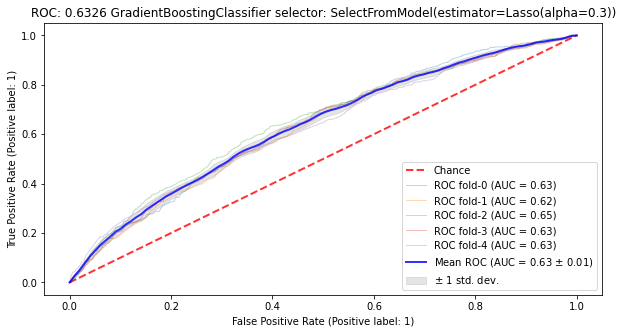

0.6325710585050408


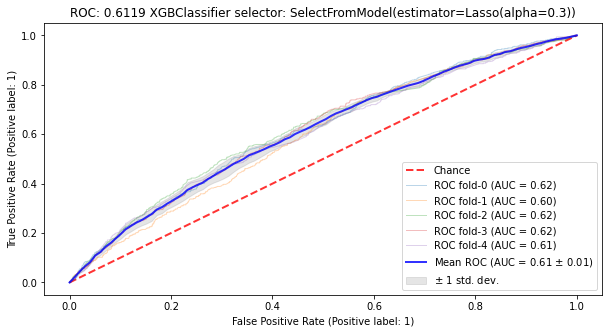

0.6119217459881601


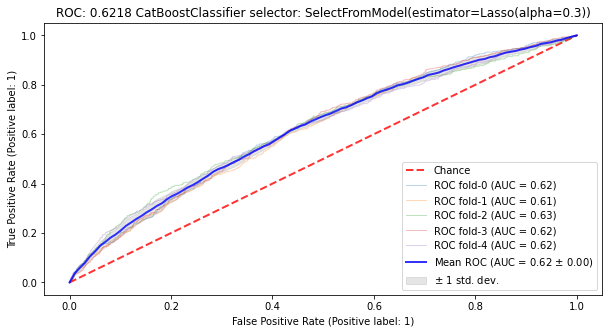

0.6218273163682362


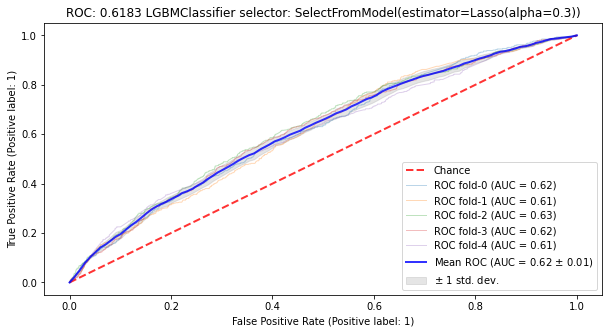

0.6183355534858929


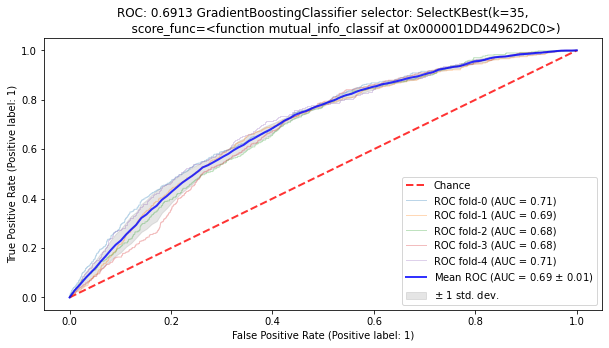

0.6913444422998561


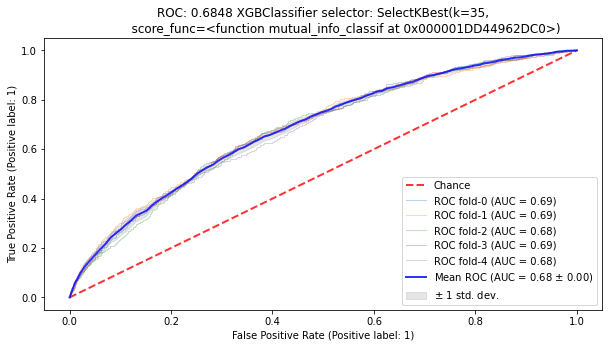

0.6847905809689249


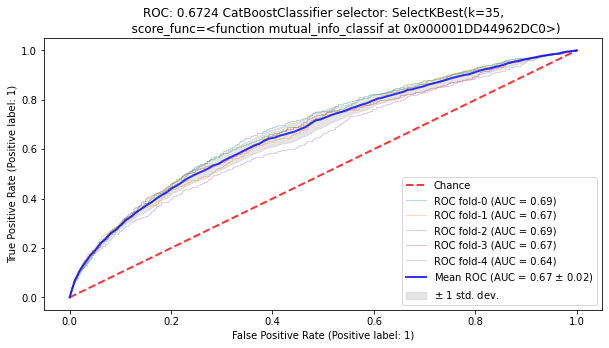

0.6723948615668361


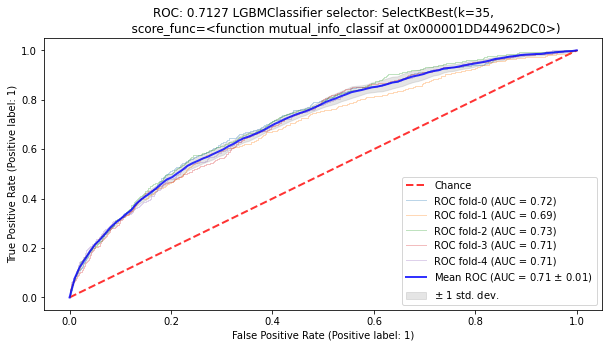

0.7127345643269211


In [102]:
num_transformer = make_pipeline(
    SimpleImputer(missing_values=np.nan, strategy='constant'),
)

cat_transformer = make_pipeline(
    SimpleImputer(missing_values=np.nan, strategy='constant'),
    OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
    # CountEncoder(handle_unknown='value'),
    # StandardScaler(),
)

preprocessor = make_column_transformer(
    (num_transformer, num_features_all),
    (cat_transformer, cat_features_all),
)

selectors = [
    SelectFromModel(LogisticRegression(
        C=10, penalty='l1', solver='liblinear')),
    SelectFromModel(Lasso(alpha=0.3)),
    SelectKBest(score_func=mutual_info_classif, k=35)
]

for selector in selectors:
    for clf in classifiers:
        pipe = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('bfeature_selection', selector),
            ('classifier', clf),
        ])

        CrossValidateReport(pipe, X_train, y_train, cv).plot(
            title=f'selector: {selector}')

## Подбор параметров

### GradientBoostingClassifier

Fitting 3 folds for each of 16 candidates, totalling 48 fits


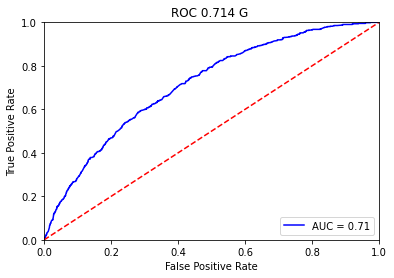

({'classifier__learning_rate': 0.1,
  'classifier__max_depth': 2,
  'classifier__n_estimators': 100,
  'classifier__subsample': 0.8},
 0.6959513429692414)

In [10]:
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)

num_transformer = make_pipeline(
    SimpleImputer(missing_values=np.nan, strategy='constant'),
)

cat_transformer = make_pipeline(
    SimpleImputer(missing_values=np.nan, strategy='constant'),
    #OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1),
    CountEncoder(handle_unknown='value'),
    StandardScaler(),
)

preprocessor = make_column_transformer(
    (num_transformer, num_features_all),
    (cat_transformer, cat_features_all),
)

pipe = imb_pipe.Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('selector', SelectFromModel(Lasso(alpha=0.1), max_features=35)),
    ('sampler', SMOTEENN(sampling_strategy=0.5, random_state=0, n_jobs=-1)),
    ('classifier', GradientBoostingClassifier(n_iter_no_change=20,
     max_features='sqrt')),
])

params = {}
params['classifier__n_estimators'] = [100, 300]
params['classifier__learning_rate'] = [0.1, 0.2]
params['classifier__max_depth'] = [2, 8]
params['classifier__subsample'] = [0.8, 1.0]

grid = GridSearchCV(pipe, param_grid=params, scoring='roc_auc',
                    cv=cv, n_jobs=-1, verbose=2, error_score='raise')
grid.fit(X_train, y_train)

RocAucScoring(grid.best_estimator_).fit_test(X_test, y_test).plot()

grid.best_params_, grid.best_score_

## Анализ признаков

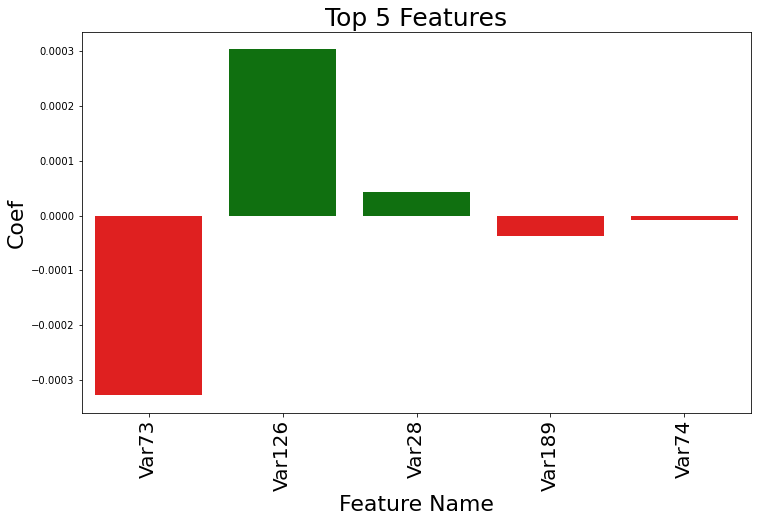

In [103]:
feature_importance_report(grid.best_estimator_)

## Анализ объектов

<AxesSubplot:xlabel='pca-one', ylabel='pca-two'>

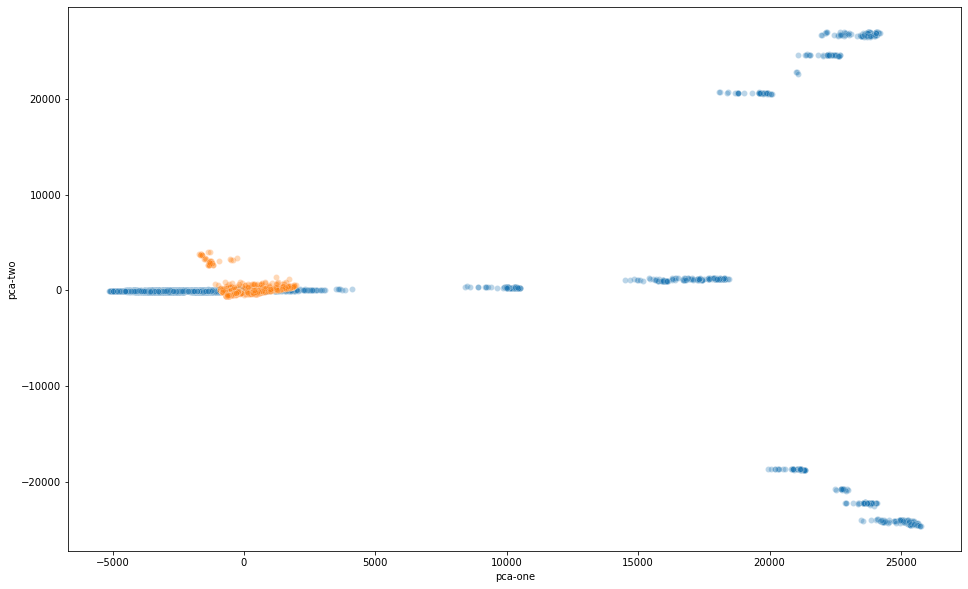

In [176]:
def pca(df):
    filled = SimpleImputer(missing_values=np.nan,
                           strategy='constant').fit_transform(df.iloc[:, :230])
    encoded = CountEncoder(handle_unknown='value').fit_transform(filled)

    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(encoded)
    df_pca = pd.DataFrame()
    df_pca['pca-one'] = pca_result[:, 0]
    df_pca['pca-two'] = pca_result[:, 1]

    return df_pca


df = pd.DataFrame(X_test)
df['target'] = y_test
df['predict'] = pipe.predict(X_test)
df['error_type'] = df.apply(
    lambda row: 'false positive' if row.target == 0 and row.predict == 1 else 'false negative', axis=1)

incorrect_predict = df[df.target != df.predict]
correct_predict = df[df.target == df.predict]

incorrect = pca(incorrect_predict)
correct = pca(correct_predict)

plt.figure(figsize=(16, 10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    palette=sns.color_palette("hls", 10),
    data=correct,
    alpha=0.3,
)


sns.scatterplot(
    x="pca-one", y="pca-two",
    palette=sns.color_palette("hls", 10),
    data=incorrect,
    legend="full",
    alpha=0.3
)

In [177]:
incorrect_predict.error_type.value_counts()

false positive    538
false negative    469
Name: error_type, dtype: int64

Часть ошибок можно объяснить выбросами. Признаки остальных объектов слабо отличаются между собой.

# Итоги проектирования

Была выбрана реализация градиентного бустинга от sklearn - GradientBoostingClassifier/
Параметры:
    learning_rate': 0.1,
    max_depth': 2,
    n_estimators': 100,
    subsample': 1.0
    
Пропуски в данных были заполнены константами. Т.к. данные сильно разреженны, то сложные алгоитмы не имеет смысла использовать.
Категориальный признаки были закодированиы с помощью CountEncoder, и после стандартизированы через StandardScaler.
Отбор фич произведен с помощью Lasso, max_features = 35
Для выравнивания баласнса класса использована комбинация оверсемплинга и андерсемплинга SMOTEENN.
roc_auc на hold-out датасете ~0.7123

Улучшение модели:
1. Провести инженеринг категориальных фич. Возможно объединить какие-то категории между собой, применить разные энкодеры к разным фичам.
2. Выкинуть выбросы
3. Проанализировать ошибки. Возможно задать этим объектам вес побольше на обучении.
4. Тщательней подобрать параметры классификатора. Можно рассмотреть использование RandomizedSearchCV вместо GridSearchCV. Или сторонние решения для тюнинга параметров


# Экономический эффект

## Загрузка данных

In [426]:
data = pd.DataFrame()
data['predict'] = grid.best_estimator_.predict_proba(X_test)[:,1]
data['predict_label'] = grid.best_estimator_.predict(X_test)
data['real_churn'] = y_test
data.to_csv('predict')

## Прогноз

Создадим простую экономическую модель для оценки воздействия полученной модели оттока. Определим экономический эффект, как разницу дохода без проведения компании по удержанию, и дохода при проведении компании по удержанию.  

Доход удержание = (доход с лояльных пользователей + доход с удержанных пользователи) - затраты на удержание  
Доход удержание = доход с лояльных пользователей - доход с оттока пользователей  

In [417]:
from functools import reduce


def top_p(df, sort_by, percentage):
    df = df.sort_values(by='predict', ascending=False)
    percentile_index = int(len(df) * percentage)
    return df[:percentile_index]


def economic_effect_model(users_df, involved_rate, user_retention_cost=10, avg_revenue_per_user=15, churn_return_rate=0.5,
                          model_quality=None):   
    if model_quality:
        # Для моделирования повышения качества модели, просто выкинем процент ошибок из текущей.
        # Это будет анлогично улучшению roc_auc, тк мы выкидываем ошибки первого и второго рода. 
        error_indexes = users_df.index[users_df.predict_label != users_df.real_churn]
        users_df = users_df.drop(index=error_indexes[:int(len(error_indexes) * (model_quality - 1))])
    
    retention_users_df = top_p(
        users_df, sort_by='predict', percentage=involved_rate)

    users_count = len(users_df)
    retention_users_count = len(retention_users_df)
    retention_churn_count = len(
        retention_users_df[retention_users_df.real_churn == 1])
    churn_return_count = retention_churn_count * churn_return_rate
    churn_count = len(users_df.real_churn == 1)
    churn_after_retention_count = churn_count - churn_return_count

    # затраты на кампанию
    retention_cost = user_retention_cost * retention_users_count

    # доход при проведении компании
    retention_revenue = (
        users_count - churn_after_retention_count) * avg_revenue_per_user
    retention_profit = retention_revenue - retention_cost

    # доход без компании
    no_retention_profit = (users_count - churn_count) * avg_revenue_per_user

    return retention_profit - no_retention_profit


def get_max_profit_values(involved, profit):
    def get_max_pairwaise(prev, current):
        _, b_prev = prev
        _, b_current = current

        if b_current > b_prev:
            return current
        else:
            return prev

    return reduce(get_max_pairwaise, zip(involved, profit))

def get_retention_profit(involved_rate, data, quality, kwargs):
    return [economic_effect_model(data, x, model_quality=quality, **kwargs) for x in involved_rate]

'Топ для применения удержания: 4.67%'

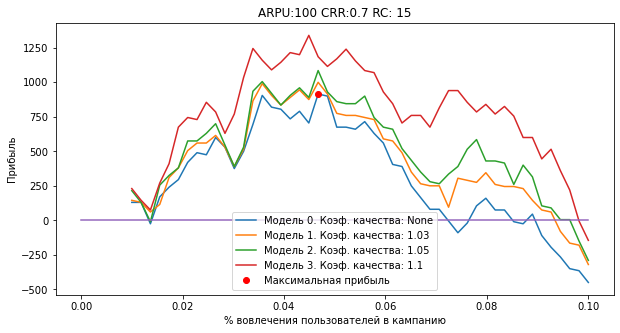

In [425]:
# Параметры кампании по удержанию
comon_params = {
    'avg_revenue_per_user': 100,
    'churn_return_rate': 0.7,
    'user_retention_cost': 15,
}

max_involved_rate = 0.1
involved_rate = np.linspace(0.01, max_involved_rate, 50)

model_qulities = [None, 1.03, 1.05, 1.1]
profits = [get_retention_profit(involved_rate, data, quality, comon_params) for quality in model_qulities]

plt.figure(figsize=(10, 5)) 
for i, (quality, profit) in enumerate(zip(model_qulities, profits)):
    plt.plot(involved_rate, profit, label=f'Модель {i}. Коэф. качества: {quality}')

best_rate, max_profit = get_max_profit_values(involved_rate, profit_1)
plt.plot(best_rate, max_profit, 'ro', label=f'Максимальная прибыль')

plt.ylabel(f'Прибыль')
plt.xlabel('% вовлечения пользователей в кампанию')
plt.plot([0, max_involved_rate], [0, 0])
plt.title(f'ARPU:{avg_revenue_per_user} CRR:{churn_return_rate} RC: {user_retention_cost}')
plt.legend()

f'Топ для применения удержания: {round(best_rate * 100, 2)}%'

 Значения ниже прямой - модель не эффективна. Максимальная эффективность отмечена красной точкой на графике.  
 При использовании текущей модели, и параметрах: средний доход с пользователя = 100, доля возврата пользователей = 0.8, стоимость удержания = 15; наибольшая выгода будет достигнута при применении удержания к топ 4.67% пользователей, для которых наиболее веротен отток.
Улучшение качества модели на 10% процентов дает серезный прирост прибыли, но небольшие приросты качество сушественно не влияют.